<a href="https://www.kaggle.com/code/vanpatangan/readmission-analysis-shap?scriptVersionId=207734020" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
#pip install shap

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

import warnings
warnings.filterwarnings("ignore")

# Apply the default theme
sns.set_theme()

# Load data
readmission = pd.read_csv('/kaggle/input/health-reentry-analysis/readmission_data (1).csv')

In [3]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns
    ]

    # Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])

    return df_check

print("Readmission Data Summary")
display(check(readmission))
display(readmission.head())

Readmission Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,patient_id,int64,1000,1000,0,0
1,admission_date,object,1000,549,0,0
2,num_diagnoses,int64,1000,10,0,0
3,num_procedures,int64,1000,6,0,0
4,num_external_injuries,int64,1000,4,0,0
5,length_of_stay,int64,1000,30,0,0
6,median_household_income,float64,1000,996,0,0
7,insurance_type,object,1000,3,0,0
8,age,int64,1000,73,0,0
9,gender,object,1000,2,0,0


,patient_id,admission_date,num_diagnoses,num_procedures,num_external_injuries,length_of_stay,median_household_income,insurance_type,age,gender,readmitted,diagnoses,external_injuries,home,facility,homeless,discharge_date
0,3790,2024-06-23 08:04:45.859854,7,0,3,27,37.684,private,62,female,0,Kidney Disease,Electrocution,yes,no,no,2024-07-20 08:04:45.859854
1,2900,2023-08-17 08:04:45.859854,4,3,2,28,31.207,private,60,male,0,COPD,Sprain,yes,yes,no,2023-09-14 08:04:45.859854
2,9648,2023-03-24 08:04:45.859854,8,2,3,27,76.099,private,30,female,0,Liver Disease,Burn,no,no,no,2023-04-20 08:04:45.859854
3,1356,2024-02-11 08:04:45.859854,5,3,0,15,97.496,self-pay,30,female,0,Mental Health,Dislocation,yes,no,no,2024-02-26 08:04:45.859854
4,9989,2023-04-17 08:04:45.859854,7,3,3,11,96.093,public,77,female,0,Cancer,Poisoning,no,no,no,2023-04-28 08:04:45.859854


In [4]:
# Convert to datetime format
readmission['admission_date'] = pd.to_datetime(readmission['admission_date'])
readmission['discharge_date'] = pd.to_datetime(readmission['discharge_date'])

# Visualization

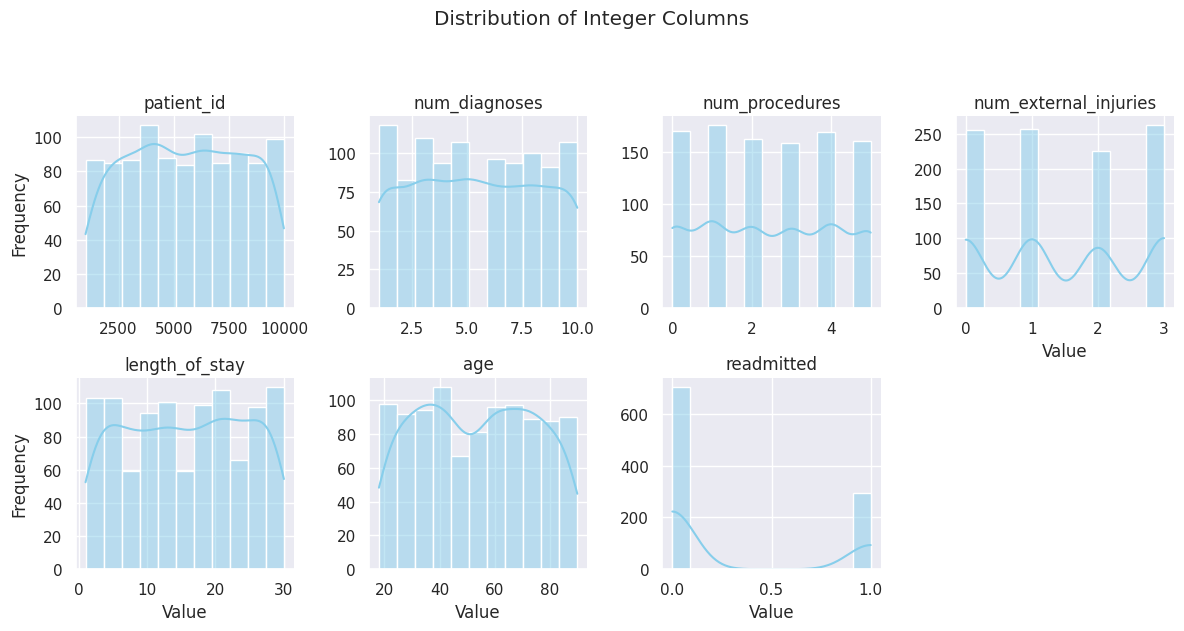

In [5]:
# Select integer columns
int_cols = readmission.select_dtypes(include='int64').columns

# Melt the dataset to use with FacetGrid
melted_data = readmission[int_cols].melt(var_name="Column", value_name="Value")

# Set up the grid
g = sns.FacetGrid(melted_data, col="Column", col_wrap=4, height=3, sharex=False, sharey=False)
g.map(sns.histplot, "Value", kde=True, color="skyblue")

# Adjust layout
g.set_titles("{col_name}")
g.set_axis_labels("Value", "Frequency")
g.fig.suptitle("Distribution of Integer Columns", y=1.05)
plt.tight_layout()
plt.show()

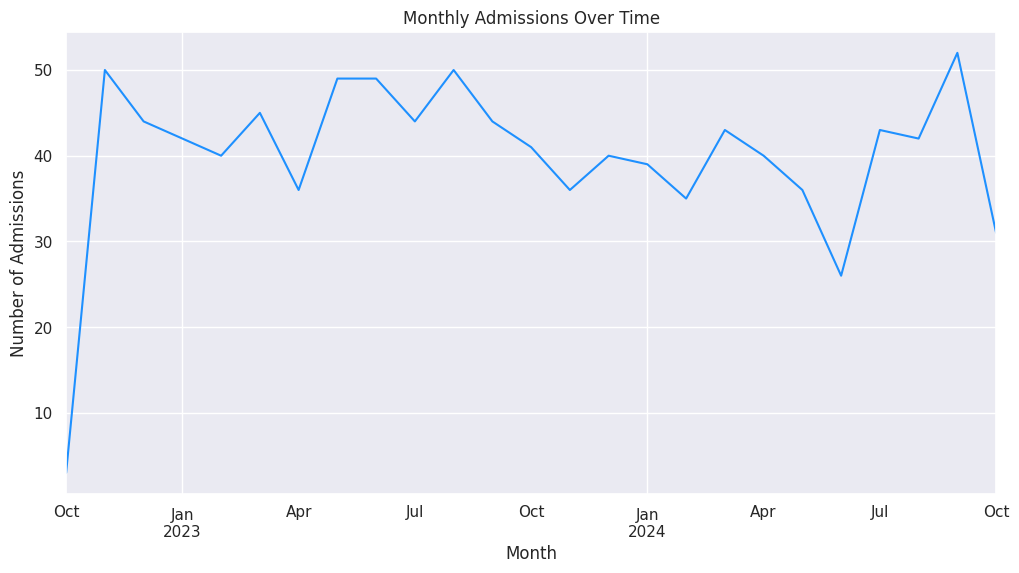

In [6]:
# Group by the month-year period and count occurrences
monthly_counts = readmission.groupby(readmission['admission_date'].dt.to_period('M')).size()

# Plot
plt.figure(figsize=(12, 6))
monthly_counts.plot(kind='line', color='dodgerblue')
plt.title("Monthly Admissions Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Admissions")
plt.show()

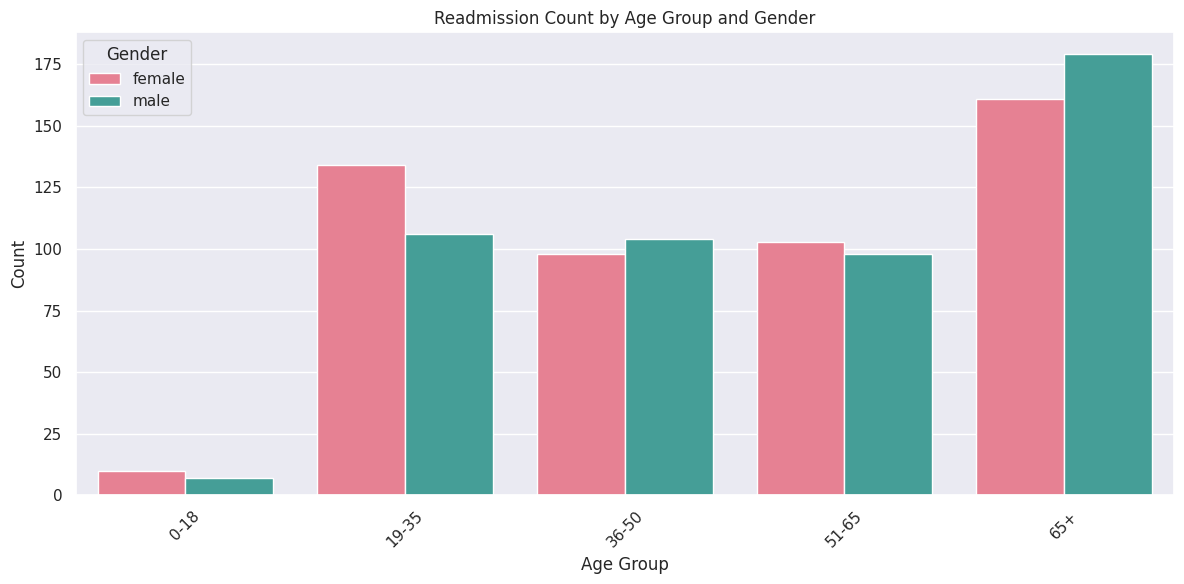

In [7]:
# Define age groups
bins = [0, 18, 35, 50, 65, 100]
labels = ['0-18', '19-35', '36-50', '51-65', '65+']

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(data=readmission, 
              x=pd.cut(readmission['age'], bins=bins, labels=labels),
              hue='gender', 
              palette="husl", 
              dodge=True)

plt.title("Readmission Count by Age Group and Gender")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.legend(title="Gender")
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

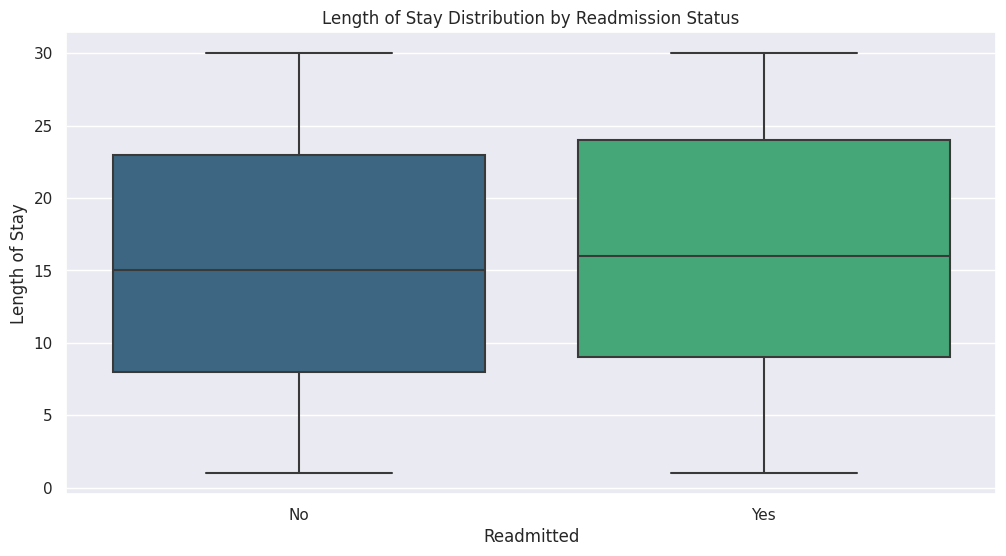

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=readmission, x='readmitted', y='length_of_stay', palette="viridis")
plt.title("Length of Stay Distribution by Readmission Status")
plt.xlabel("Readmitted")
plt.ylabel("Length of Stay")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

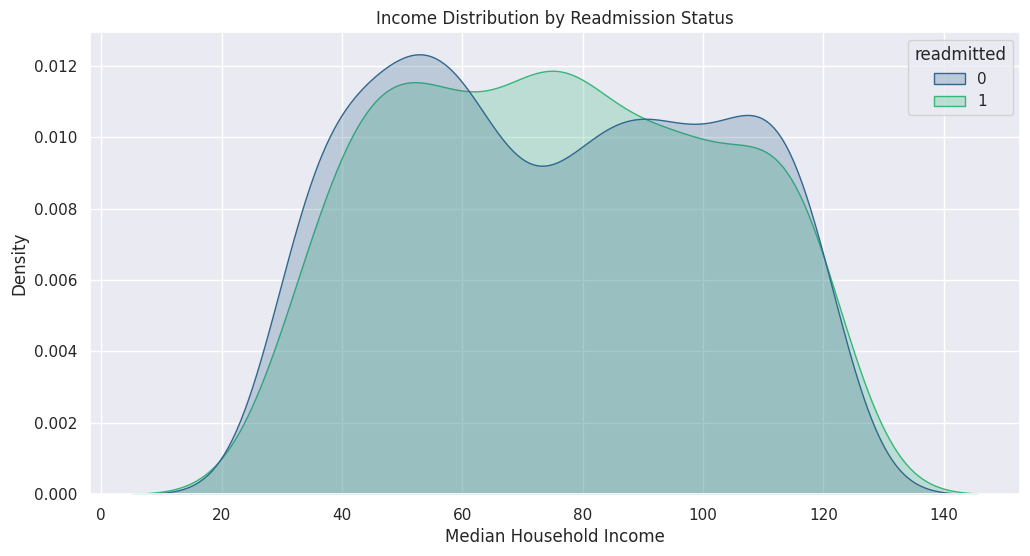

In [9]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=readmission, x='median_household_income', 
            hue='readmitted', fill=True, common_norm=False, palette="viridis")
plt.title("Income Distribution by Readmission Status")
plt.xlabel("Median Household Income")
plt.show()

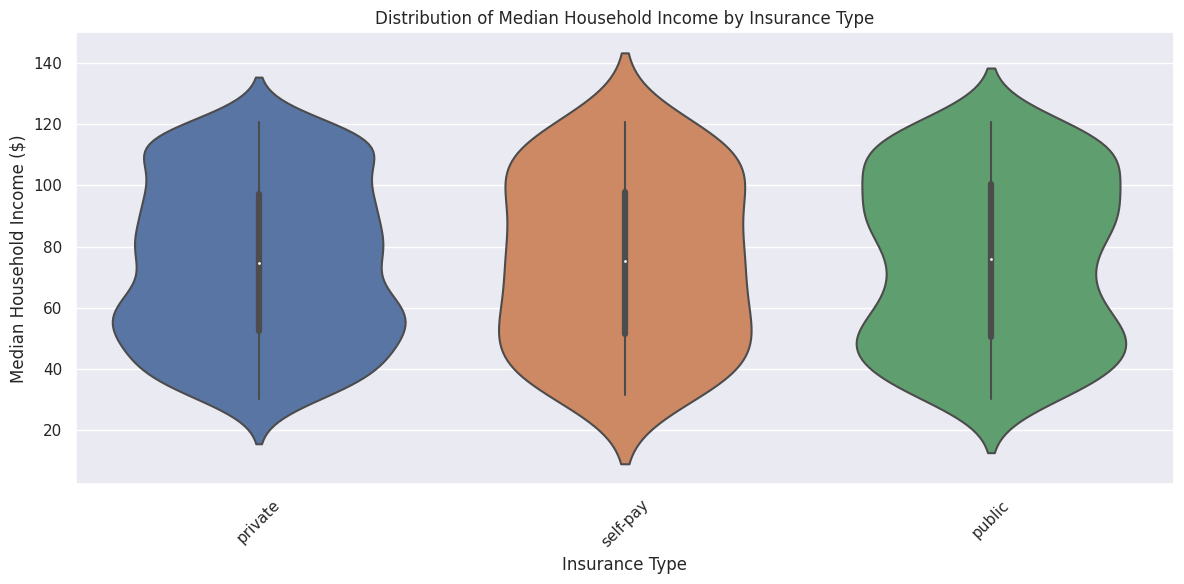

In [10]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='insurance_type', y='median_household_income', data=readmission)
plt.title('Distribution of Median Household Income by Insurance Type')
plt.xlabel('Insurance Type')
plt.ylabel('Median Household Income ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*The wider sections of the violin represent a higher probability that members of the population will take on the given value; the skinnier sections represent a lower probability.*

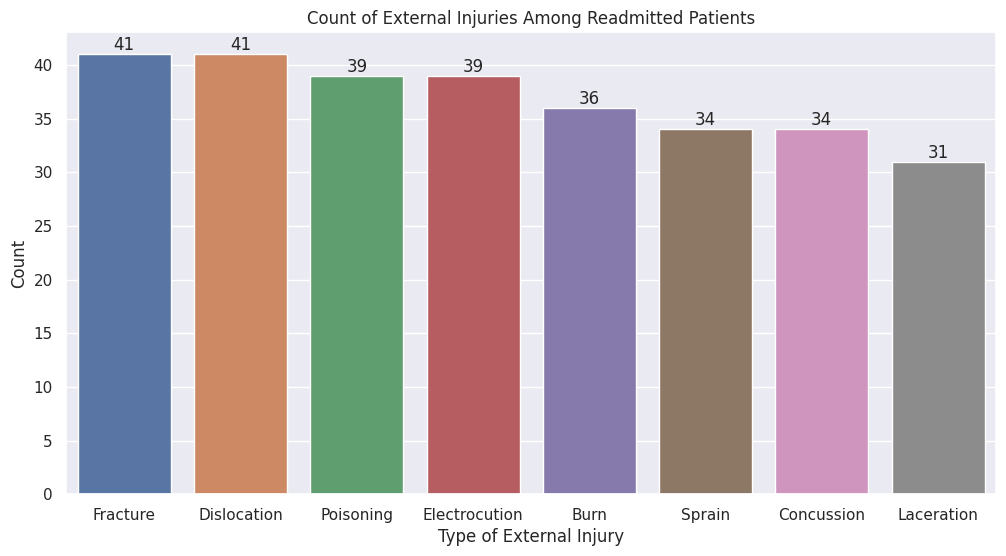

In [11]:
readmitted_df = readmission[readmission['readmitted'] == 1]

# Create the count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='external_injuries', data=readmitted_df, 
              order=readmitted_df['external_injuries'].value_counts().index)

plt.title('Count of External Injuries Among Readmitted Patients')
plt.xlabel('Type of External Injury')
plt.ylabel('Count')

# Add value labels on top of each bar
for i, v in enumerate(readmitted_df['external_injuries'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

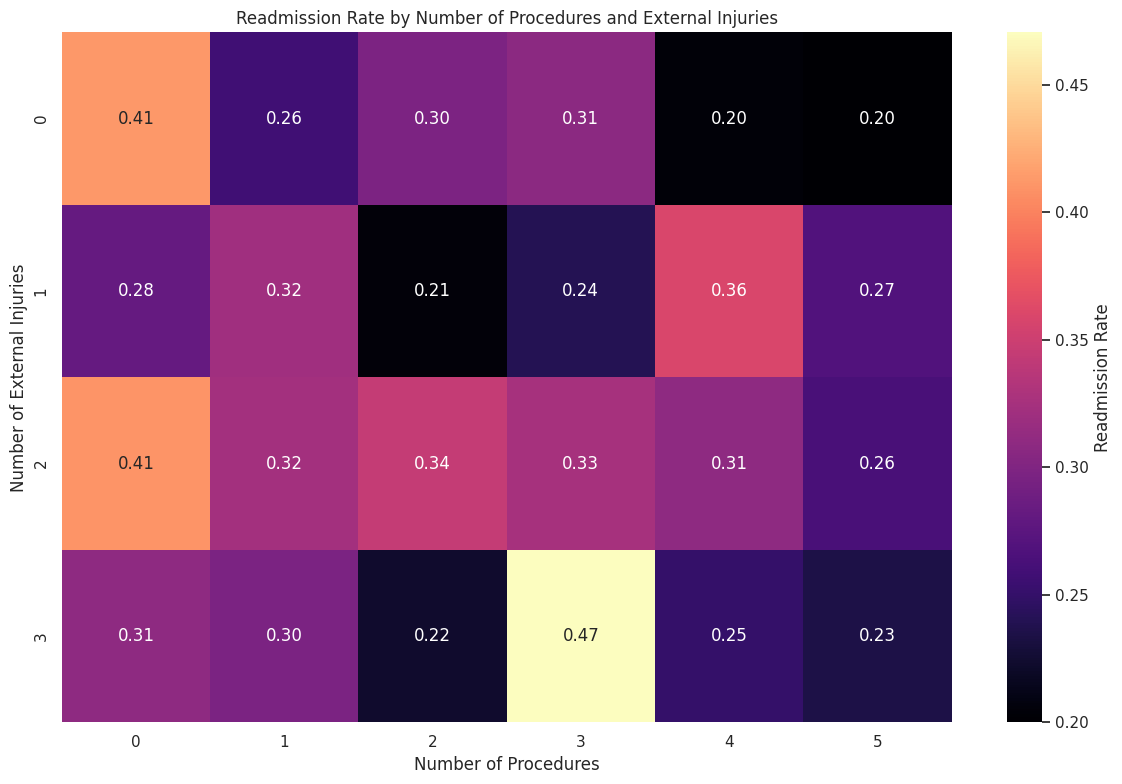

In [12]:
# Create a pivot table to aggregate the data
heatmap_data = readmission.pivot_table(
    values='readmitted',
    index='num_external_injuries',
    columns='num_procedures',
    aggfunc='mean'
)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="magma", annot=True, fmt=".2f", 
            cbar_kws={'label': 'Readmission Rate'})
plt.title("Readmission Rate by Number of Procedures and External Injuries")
plt.xlabel("Number of Procedures")
plt.ylabel("Number of External Injuries")
plt.tight_layout()
plt.show()

In [13]:
# Count the number of samples in each class
class_counts = readmission['readmitted'].value_counts()

# Determine majority and minority classes
majority_class = class_counts.index[0]
minority_class = class_counts.index[1]

# Calculate imbalance ratio
imbalance_ratio = class_counts[majority_class] / class_counts[minority_class]

print(f"Class distribution:\n{class_counts}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")

Class distribution:
readmitted
0    705
1    295
Name: count, dtype: int64
Imbalance ratio: 2.39


# Feature Engineering

In [14]:
# Extract year, month, day, hour, and weekday
readmission['admission_year'] = readmission['admission_date'].dt.year
readmission['admission_month'] = readmission['admission_date'].dt.month
readmission['admission_day'] = readmission['admission_date'].dt.day
readmission['admission_hour'] = readmission['admission_date'].dt.hour
readmission['admission_weekday'] = readmission['admission_date'].dt.weekday  # Monday=0, Sunday=6

readmission['discharge_year'] = readmission['discharge_date'].dt.year
readmission['discharge_month'] = readmission['discharge_date'].dt.month
readmission['discharge_day'] = readmission['discharge_date'].dt.day
readmission['discharge_hour'] = readmission['discharge_date'].dt.hour
readmission['discharge_weekday'] = readmission['discharge_date'].dt.weekday

In [15]:
# Drop original datetime columns
readmission.drop(columns=['admission_date', 'discharge_date'], inplace=True)

In [16]:
# Income and Age interaction
readmission['income_age_interaction'] = readmission['median_household_income'] * readmission['age']

# Income to Length of Stay Ratio
readmission['income_stay_ratio'] = readmission['median_household_income'] / readmission['length_of_stay']
readmission['income_stay_ratio'].replace([np.inf, -np.inf], 0, inplace=True)  # Handle divisions by zero if length of stay is zero

# Income insurance interaction
readmission['insurance_type_encoded'] = readmission['insurance_type'].factorize()[0]
readmission['income_insurance_interaction'] = readmission['median_household_income'] * readmission['insurance_type_encoded']

In [17]:
# Total medical events
readmission['total_medical_events'] = readmission['num_diagnoses'] + readmission['num_procedures'] + readmission['num_external_injuries']

In [18]:
# Diagnosis and procedure interaction
readmission['diagnosis_procedure_interaction'] = readmission['num_diagnoses'] * readmission['num_procedures']

In [19]:
# Risk flag by age
readmission['age_risk_flag'] = pd.cut(readmission['age'], 
                                      bins=[0, 50, 65, float('inf')], 
                                      labels=[0, 1, 2], 
                                      include_lowest=True)

In [20]:
# Risk flag by external_injury
def create_severity_flag(injury):
    high_severity_injuries = ['Fracture', 'Dislocation', 'Electrocution', 'Concussion', 'Poisoning', 'Burn']
    return 1 if injury in high_severity_injuries else 0

readmission['injury_severity_flag'] = readmission['external_injuries'].apply(create_severity_flag)

In [21]:
# Risk flag by diagnosis
def create_diagnosis_risk_flag(diagnosis):
    high_risk_diagnoses = [
        'Cancer', 'Mental Health', 'Kidney Disease', 
        'Heart Disease', 'COPD', 'Liver Disease'
    ]
    return 1 if diagnosis in high_risk_diagnoses else 0

readmission['diagnosis_risk_flag'] = readmission['diagnoses'].apply(create_diagnosis_risk_flag)

In [22]:
# Define risk weights
weights = {'home': 1, 'facility': 2, 'homeless': 3}

# Calculate risk score
readmission['discharge_destination_risk_score'] = (
    readmission['home'].apply(lambda x: weights['home'] if x == 'yes' else 0) +
    readmission['facility'].apply(lambda x: weights['facility'] if x == 'yes' else 0) +
    readmission['homeless'].apply(lambda x: weights['homeless'] if x == 'yes' else 0)
)

# Create an is_homeless_flag column
readmission['is_homeless_flag'] = readmission['homeless'].apply(lambda x: 1 if x == 'yes' else 0)

In [23]:
# Remove the dash from 'self-pay'
readmission['insurance_type'] = readmission['insurance_type'].str.replace('self-pay', 'selfpay')

In [24]:
# Remove columns
readmission = readmission.drop(columns=['insurance_type','diagnoses', 'external_injuries','home', 'facility', 'homeless'])

In [25]:
# One-hot encoding
readmission = pd.get_dummies(readmission, columns=['gender'], drop_first=True)

# Modeling

In [26]:

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Define features and target
X = readmission.drop(['patient_id', 'readmitted'], axis=1)
y = readmission['readmitted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weight
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

# Scale all features
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Prepare data for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Params (Used Optuna for tuning)
params = {
    'objective': 'binary',
    'metric': 'auc',  
    'boosting_type': 'gbdt',
    'n_estimators': 1992,
    'learning_rate': 0.042819863193109174,
    'num_leaves': 35,
    'min_data_in_leaf': 21,
    'scale_pos_weight': class_ratio,
    #'scale_pos_weight': 2.4188034188034186,
    'feature_fraction': 0.8013644929185787,
    'bagging_fraction': 0.7963131424726917,
    'bagging_freq': 2,
    'lambda_l1': 0.00047553996404738985,
    'lambda_l2': 0.3868974034219026,
    'verbose': -1,
}


# Train the model
num_round = 1000  
model = lgb.train(params, train_data, 
                  num_boost_round=num_round, 
                  valid_sets=[train_data, test_data],
                  callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)
y_proba = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

Accuracy: 0.69
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79       139
           1       0.49      0.33      0.39        61

    accuracy                           0.69       200
   macro avg       0.61      0.59      0.59       200
weighted avg       0.66      0.69      0.67       200

AUC-ROC: 0.6201202972048591


# Evaluation

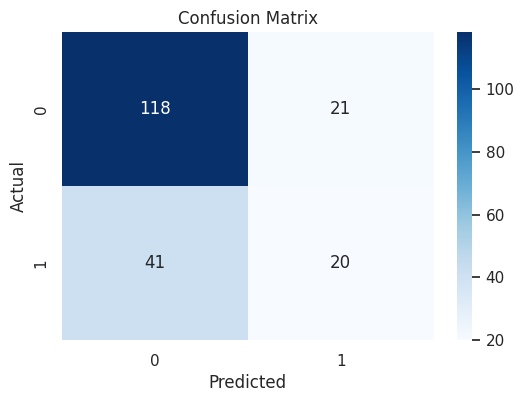

In [27]:
from sklearn.metrics import confusion_matrix

# Show the model's prediction accuracy for each class
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

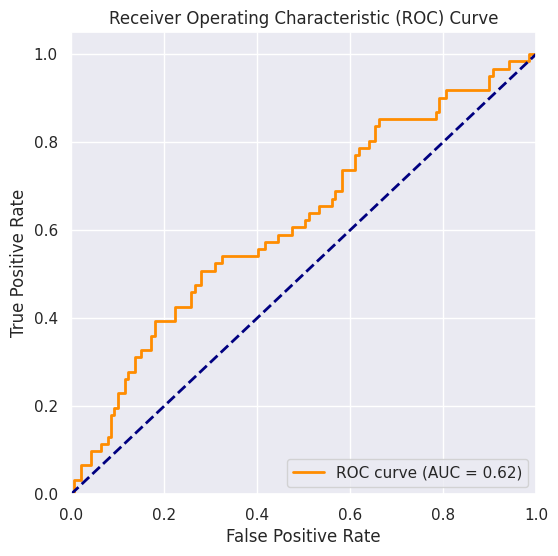

In [28]:
from sklearn.metrics import roc_curve, auc

# Visualize trade-off between true positive rate and false positive rate
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [29]:
# Initialize SHAP explainer 
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

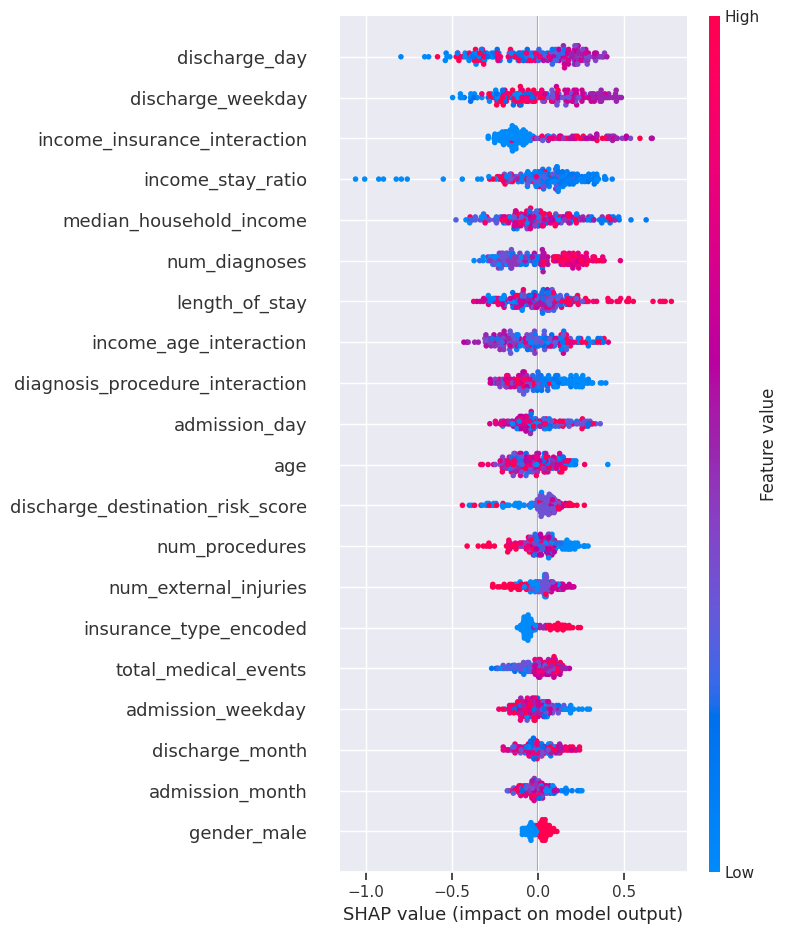

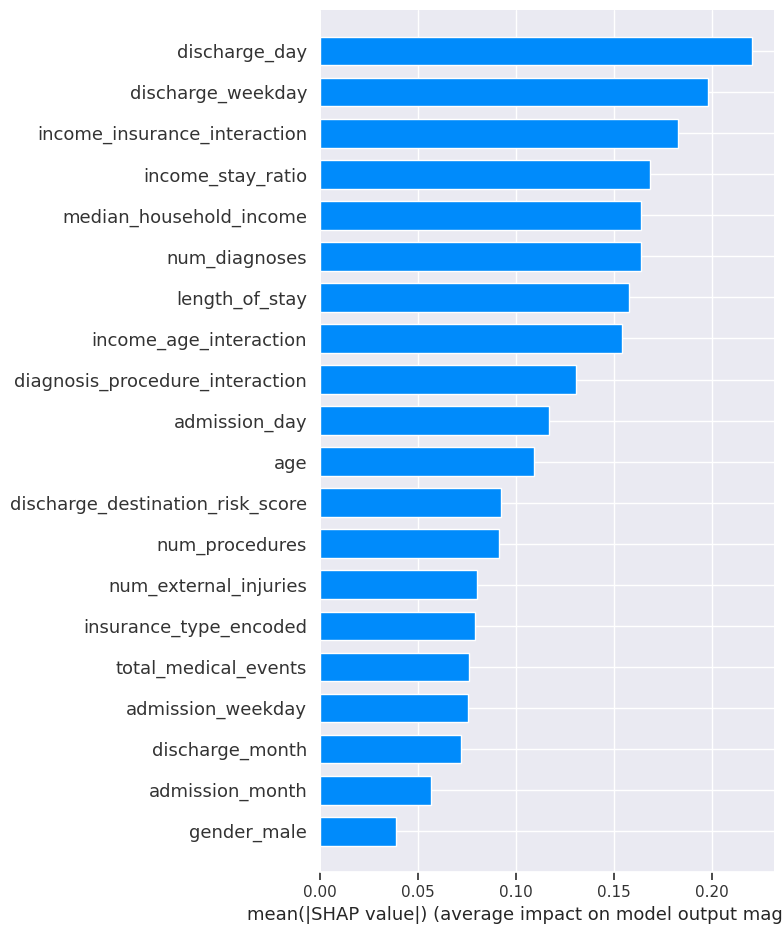

In [30]:
# Shows the average magnitude and direction of SHAP values for each feature across all samples
shap.summary_plot(shap_values[1], X_test)

# Ranks features by their average absolute SHAP value
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

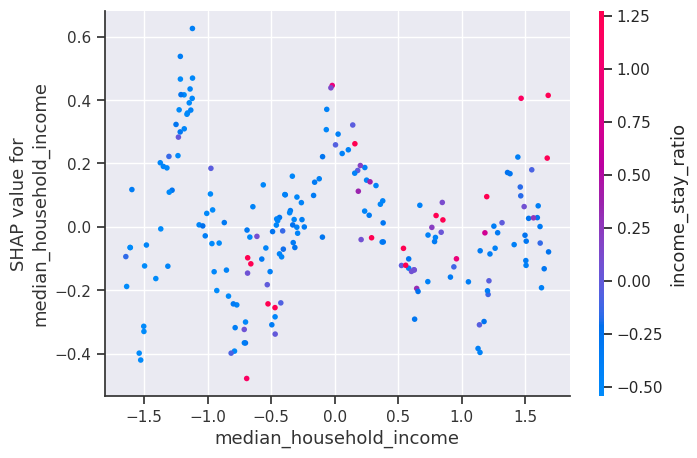

In [31]:
shap.dependence_plot("median_household_income", shap_values[1], X_test)

**Observations**

**Feature Effect:**

*For lower values of median_household_income (e.g., < -0.5), SHAP values are mostly negative, meaning that low income decreases the likelihood of readmission (or contributes less to the positive class).
For higher values of median_household_income (e.g., > 0), SHAP values are positive, meaning that higher income increases the likelihood of readmission.*

**Interaction with income_stay_ratio:**

*The color gradient shows interaction effects. For example:
Red points (higher income_stay_ratio) often appear in regions with positive SHAP values, indicating that high income combined with a high stay ratio increases the likelihood of readmission.
Blue points (lower income_stay_ratio) are spread across SHAP values, but their effect might depend on the value of median_household_income.*

**Scatter Pattern:**

*A scattered pattern suggests no simple linear relationship between median_household_income and its SHAP values, indicating a more complex or non-linear influence on the model's prediction.*